In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature

In [2]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=ae7627a64c30d5db1adf789f147b9fe7c6d0d446f435adeb7d05271d873cfe38
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Opening datasets

In [3]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta.head()

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0


time: 1.29 s


# Getting part of the dataset
Não coloquei 10% dele, pois poderiam vir mais datasets de um label específico. E nem coloquei 10% de cada label, pois a quantidades de datasets dentro de cada label é diferente. Então defini n datasets de cada label.

In [10]:
df = df_meta.groupby('scene_label', as_index=False).apply(lambda x: x.sample(n = 10, random_state=15))
df.index = [i[1] for i in df.index]
df.head()

,filename,scene_label,identifier
3028,audio/metro_station-helsinki-231-6952-a.wav,indoor,helsinki-231
9493,audio/shopping_mall-milan-1183-45376-a.wav,indoor,milan-1183
4163,audio/metro_station-stockholm-85-2308-a.wav,indoor,stockholm-85
3224,audio/metro_station-lisbon-1020-42471-a.wav,indoor,lisbon-1020
9294,audio/shopping_mall-lyon-1066-42583-a.wav,indoor,lyon-1066


time: 26 ms


In [11]:
print(df.loc[df['scene_label'] == 'outdoor'].shape)
print(df.loc[df['scene_label'] == 'indoor'].shape)
print(df.loc[df['scene_label'] == 'transportation'].shape)

(10, 3)
(10, 3)
(10, 3)
time: 7.88 ms


Reading the datasets and storing it to 'signals'

In [12]:
info_sound = df[['filename','scene_label']].to_numpy()
LABELS = ['indoor', 'outdoor', 'transportation']

time: 5.47 ms


In [15]:
dic_signals = {x:[] for i, x in enumerate(LABELS)}

for filename, label in info_sound:
    #print(filename, label)
    if(path.isfile(os.path.join(DIR_AUDIO, filename))):
        dic_signals[label].append(sf.read(os.path.join(DIR_AUDIO, filename)))
        continue
    else:
        print(filename)

#signals = np.asarray(signals)

audio/shopping_mall-prague-1219-44349-a.wav
audio/street_pedestrian-lisbon-1004-40735-a.wav
audio/street_pedestrian-barcelona-141-4300-a.wav
audio/tram-milan-1222-44502-a.wav
audio/metro-stockholm-57-1703-a.wav
audio/tram-lyon-1112-43455-a.wav
audio/tram-lyon-1225-45564-a.wav
time: 19 s


In [16]:
len(dic_signals.get('transportation'))

6

time: 3.99 ms


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS


In [17]:
def get_features(dic_signals)->pd.DataFrame:
    def get_centroid(S):
        return librosa.feature.spectral_centroid(S=S)
    def get_flatness(S):
        return librosa.feature.spectral_flatness(S=S)
    def get_rms(s):
        return librosa.feature.rms(s, hop_length=1024)
    def stft(signal):
        return np.abs(librosa.stft(signal[:,0], hop_length=1024))

    info = {'Centroid Mean':[], 
        'Centroid STD': [], 
        'Flatness Mean':[],
        'Flatness STD':[],
        'RMS':[],
        'Target': []} 
    for label, signals in dic_signals.items():
        i = 1
        for signal, samplerate in signals:
            #print(i)
            stft_transform = stft(signal)
            mel = librosa.feature.melspectrogram(y=signal[:,0],sr=samplerate)
            info['Target'].append(label)
            c = get_centroid(mel)
            c = c[0]
            info['Centroid Mean'].append(np.mean(c))
            info['Centroid STD'].append(np.std(c))
            f = get_flatness(mel)
            f = f[0]
            info['Flatness Mean'].append(np.mean(f))
            info['Flatness STD'].append(np.std(f))
            r = get_rms(mel)
            r = round(r[0][0],3)
            info['RMS'].append(r) 
            i += 1
    return pd.DataFrame(info)
        


time: 29.9 ms


In [18]:
df = get_features(dic_signals)
df

,Centroid Mean,Centroid STD,Flatness Mean,Flatness STD,RMS,Target
0,361.191092,190.575939,8.318718e-05,1.376274e-04,0.002,indoor
1,678.002825,223.700505,1.373056e-04,1.980706e-04,0.004,indoor
2,1549.646275,322.113395,9.913436e-04,1.462120e-03,0.046,indoor
3,670.718124,236.158911,6.323809e-05,5.154674e-04,0.611,indoor
4,1139.123910,315.588389,3.377442e-03,2.949919e-03,0.000,indoor
5,1104.943624,450.989040,5.643040e-04,7.559241e-04,0.006,indoor
6,379.427770,178.839471,1.978951e-04,3.362447e-04,0.001,indoor
7,778.802857,239.771808,5.547340e-04,6.012878e-04,0.001,indoor
8,407.019774,160.118229,5.886464e-05,7.167951e-05,0.002,indoor
9,437.505044,242.542258,3.655301e-05,1.001096e-04,0.020,outdoor


time: 2.84 s


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

time: 995 µs


In [20]:
X,y = df.iloc[:,0:-1], df['Target'].values

time: 1.93 ms


In [22]:
# splitting the data into training and test sets (80:20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

time: 9.57 ms


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

time: 1.15 ms


# Building a KNN Model

In [42]:
def knn_classifier(X_train, X_test, y_train, k):
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    return [y_pred, metrics.accuracy_score(y_test,y_pred)]

def get_k_accuracy(X_train, X_test, y_train, y_test): 

    def plot_scores(x,y):
        fig, a = plt.subplots(1, figsize = (10, 8))
        title = "Accuracy Score by K values"
        plt.title(title)
        plt.xlabel('Value of K for KNN')
        plt.ylabel('Testing Accuracy')
        a.plot(x, y)

    k_range = range(1,10)
    scores = {}
    scores_list = []

    for k in k_range:
        y_pred, scores[k] = knn_classifier(X_train, X_test, y_train, k)
        scores_list.append(scores[k])

    plot_scores(list(k_range), scores_list)
    print('Accuracy: ' + str(scores[max(scores, key= scores.get)]))
    return max(scores, key= scores.get)



time: 17.8 ms


1
2
3
4
5
6
7
8
9
Accuracy: 0.6


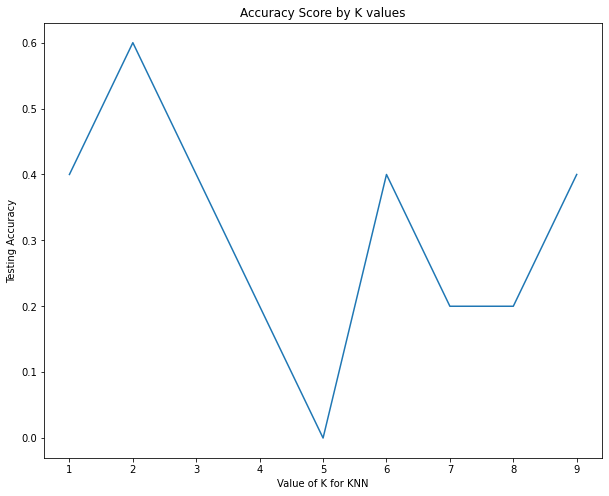

time: 265 ms


In [43]:
k = get_k_accuracy(X_train,X_test, y_train, y_test)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [44]:
a = [l for y in y_test for i, l in enumerate(LABELS) if y==i]
a

[]

time: 3.67 ms


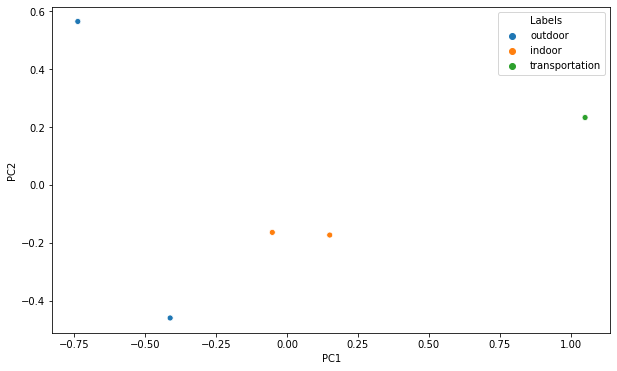

time: 385 ms


In [45]:
from sklearn.decomposition import PCA
import seaborn as sns

pca1 = PCA(2)
trans_pca1 = pca1.fit_transform(X_test)
trans_pca1 = pd.DataFrame(trans_pca1)
trans_pca1['Labels'] = y_test
#trans_pca1['Labels'] = [l for y in y_test for i, l in enumerate(LABELS) if y==i]
trans_pca1.columns = ['PC1', 'PC2', 'Labels']
trans_pca1.head()
plt.figure(figsize=(10,6))
sns.scatterplot(x=trans_pca1['PC1'], y=trans_pca1['PC2'], hue=trans_pca1['Labels'])